# Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, RobustScaler
import warnings
import math
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/application-datasets/application_train.csv
/kaggle/input/application-datasets/HomeCredit_columns_description.csv
/kaggle/input/application-datasets/application_test.csv


In [2]:
warnings.simplefilter(action='ignore', category=Warning)

# Read Dataset

In [3]:
path = '/kaggle/input/application-datasets/application_train.csv'
df_train = pd.read_csv(path)

In [4]:
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# Check Data

In [5]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


In [6]:
check_df(df_train)

##################### Shape #####################
(307511, 122)
##################### Types #####################
SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object
##################### Head #####################
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans       

# Split DataSet

Split dataset into (category, numeric, cordinal) that help us to make analysis on each kind separately

In [7]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
       veri setindeki kategorik, numeric ve kategorik fakat kardinal değişkenlerin isimlerini verir.
       Not: kategorik değikenlerin içersine numerik görünümlü ketagorik değişkenler de dahildir.

       Args:
           dataframe: dataframe
               değişken isimleri alınmak istenen dataframe'dir,
           cat_th: int, float
               numerik fakat kategorik olan değişkenler için sınıf eşik değeri.
           car_th: int, float
               kategorik fakat kardinal değişkenler için sınıf eşik değeri.

       Returns:
           cat_cols: list
               kategorik değişken listesi
           num_cols: list
               numerik değişken listesi
           cat_but_car: list
               kategorik görünümlü kardinal değişken listesi

       Notes:
           cat_cols + num_cols + cat_but_car = toplam değişken sayısı
           num_but_cat cat_cols'un içerisinde.

       """

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                                                       dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                                                       dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    #Number Columns
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    num_cols = [col for col in num_cols if dataframe[col].nunique() != len(dataframe)]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


In [8]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_train)

Observations: 307511
Variables: 122
cat_cols: 54
num_cols: 66
cat_but_car: 1
num_but_cat: 39


# Numeric Features

In [9]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(f"**********  {numerical_col} **********")
    print(dataframe[numerical_col].describe(quantiles).T)
    print("**********************************************")

    if plot:
        dataframe[numerical_col].hist()
        plt.title(numerical_col)
        plt.xlabel(numerical_col)
        plt.show(block=True)


In [10]:
for col in num_cols:
    num_summary(df_train, col)

**********  CNT_CHILDREN **********
count    307511.000000
mean          0.417052
std           0.722121
min           0.000000
5%            0.000000
10%           0.000000
20%           0.000000
30%           0.000000
40%           0.000000
50%           0.000000
60%           0.000000
70%           0.000000
80%           1.000000
90%           2.000000
95%           2.000000
99%           3.000000
max          19.000000
Name: CNT_CHILDREN, dtype: float64
**********************************************
**********  AMT_INCOME_TOTAL **********
count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
5%       6.750000e+04
10%      8.100000e+04
20%      9.900000e+04
30%      1.125000e+05
40%      1.350000e+05
50%      1.471500e+05
60%      1.620000e+05
70%      1.800000e+05
80%      2.250000e+05
90%      2.700000e+05
95%      3.375000e+05
99%      4.725000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64
**************************************

# Outlier

## Check Outlier

In [11]:
def outlier_threshold(dataframe, col_name, q1=0.25, q3=0.75):
    quantile1 = dataframe[col_name].quantile(q1)
    quantile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quantile3 - quantile1
    up_limit = quantile3 + 1.5 * interquantile_range
    low_limit = quantile1 - 1.5 * interquantile_range
    return up_limit, low_limit


In [12]:
def check_outliers(dataframe, col_name, q1= 0.25, q3=0.75):
    up_limit, low_limit = outlier_threshold(dataframe, col_name, q1, q3)
    return dataframe[(dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit)].any(axis=None)


In [13]:
box_list = []
for col in num_cols:
    print(col, " ", check_outliers(df_train, col))
    if check_outliers(df_train, col):
        box_list.append(col)

CNT_CHILDREN   True
AMT_INCOME_TOTAL   True
AMT_CREDIT   True
AMT_ANNUITY   True
AMT_GOODS_PRICE   True
REGION_POPULATION_RELATIVE   True
DAYS_BIRTH   False
DAYS_EMPLOYED   True
DAYS_REGISTRATION   True
DAYS_ID_PUBLISH   False
OWN_CAR_AGE   True
CNT_FAM_MEMBERS   True
HOUR_APPR_PROCESS_START   True
EXT_SOURCE_1   False
EXT_SOURCE_2   False
EXT_SOURCE_3   False
APARTMENTS_AVG   True
BASEMENTAREA_AVG   True
YEARS_BEGINEXPLUATATION_AVG   True
YEARS_BUILD_AVG   True
COMMONAREA_AVG   True
ELEVATORS_AVG   True
ENTRANCES_AVG   True
FLOORSMAX_AVG   True
FLOORSMIN_AVG   True
LANDAREA_AVG   True
LIVINGAPARTMENTS_AVG   True
LIVINGAREA_AVG   True
NONLIVINGAPARTMENTS_AVG   True
NONLIVINGAREA_AVG   True
APARTMENTS_MODE   True
BASEMENTAREA_MODE   True
YEARS_BEGINEXPLUATATION_MODE   True
YEARS_BUILD_MODE   True
COMMONAREA_MODE   True
ELEVATORS_MODE   True
ENTRANCES_MODE   True
FLOORSMAX_MODE   True
FLOORSMIN_MODE   True
LANDAREA_MODE   True
LIVINGAPARTMENTS_MODE   True
LIVINGAREA_MODE   True
NONLIVING

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(1, 0, 'HOUR_APPR_PROCESS_START'),
  Text(2, 0, 'APARTMENTS_AVG'),
  Text(3, 0, 'BASEMENTAREA_AVG'),
  Text(4, 0, 'YEARS_BEGINEXPLUATATION_AVG'),
  Text(5, 0, 'YEARS_BUILD_AVG'),
  Text(6, 0, 'COMMONAREA_AVG'),
  Text(7, 0, 'ELEVATORS_AVG'),
  Text(8, 0, 'ENTRANCES_AVG'),
  Text(9, 0, 'FLOORSMAX_AVG'),
  Text(10, 0, 'FLOORSMIN_AVG')])

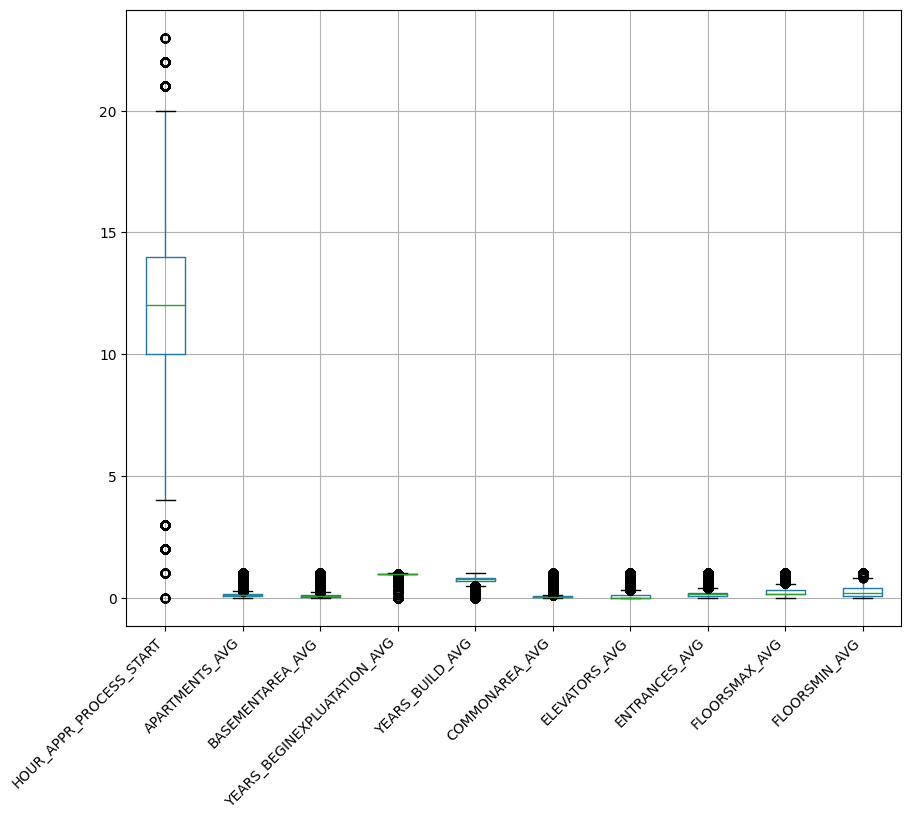

In [14]:
plt.figure(figsize=(10, 8))
df_train.boxplot(column=box_list[10:20])
plt.xticks(rotation=45, ha='right')

In [15]:
def grab_outliers(dataframe, col_name, index=False):
    up_limit, low_limit = outlier_threshold(dataframe, col_name)

    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].shape[0] > 10:
        print(dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].head())
    else:
        print(dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)])

    if index:
        outliers_index = dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].index
        return outliers_index


In [16]:
for col in num_cols:
    outliers_index =  grab_outliers(df_train, col, index=True)

     SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
91       100108       0         Cash loans           F            N   
92       100110       0         Cash loans           M            Y   
144      100166       0         Cash loans           F            N   
180      100209       1    Revolving loans           M            N   
182      100211       0         Cash loans           M            N   

    FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
91                Y             3          171000.0    545040.0      31288.5   
92                Y             3          135000.0    373140.0      25065.0   
144               Y             3           58500.0    152820.0      15241.5   
180               Y             3          180000.0    540000.0      27000.0   
182               N             3          225000.0    746280.0      49873.5   

     ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
91   ...   

In [17]:
df_train.iloc[outliers_index].head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
65,100077,0,Cash loans,M,N,Y,0,180000.0,1256400.0,40657.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,8.0
105,100124,0,Cash loans,M,N,Y,0,225000.0,448272.0,28647.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,8.0
200,100233,0,Cash loans,F,N,Y,0,216000.0,679671.0,28926.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,8.0
284,100327,0,Cash loans,M,Y,Y,0,180000.0,407727.0,32341.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,9.0
334,100383,0,Cash loans,M,Y,N,2,180000.0,640080.0,20929.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,9.0


In [18]:
def replace_with_thresholds(dataframe, variable):
    up_limit, low_limit = outlier_threshold(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


In [19]:
for col in num_cols:
    replace_with_thresholds(df_train, col)

In [20]:
for col in num_cols:
    print(col, " ", check_outliers(df_train, col))

CNT_CHILDREN   False
AMT_INCOME_TOTAL   False
AMT_CREDIT   False
AMT_ANNUITY   False
AMT_GOODS_PRICE   False
REGION_POPULATION_RELATIVE   False
DAYS_BIRTH   False
DAYS_EMPLOYED   False
DAYS_REGISTRATION   False
DAYS_ID_PUBLISH   False
OWN_CAR_AGE   False
CNT_FAM_MEMBERS   False
HOUR_APPR_PROCESS_START   False
EXT_SOURCE_1   False
EXT_SOURCE_2   False
EXT_SOURCE_3   False
APARTMENTS_AVG   False
BASEMENTAREA_AVG   False
YEARS_BEGINEXPLUATATION_AVG   False
YEARS_BUILD_AVG   False
COMMONAREA_AVG   False
ELEVATORS_AVG   False
ENTRANCES_AVG   False
FLOORSMAX_AVG   False
FLOORSMIN_AVG   False
LANDAREA_AVG   False
LIVINGAPARTMENTS_AVG   False
LIVINGAREA_AVG   False
NONLIVINGAPARTMENTS_AVG   False
NONLIVINGAREA_AVG   False
APARTMENTS_MODE   False
BASEMENTAREA_MODE   False
YEARS_BEGINEXPLUATATION_MODE   False
YEARS_BUILD_MODE   False
COMMONAREA_MODE   False
ELEVATORS_MODE   False
ENTRANCES_MODE   False
FLOORSMAX_MODE   False
FLOORSMIN_MODE   False
LANDAREA_MODE   False
LIVINGAPARTMENTS_MODE   Fa

## Missing Value

### Advanced Missin Value Anlysis

In [21]:
import missingno as msno

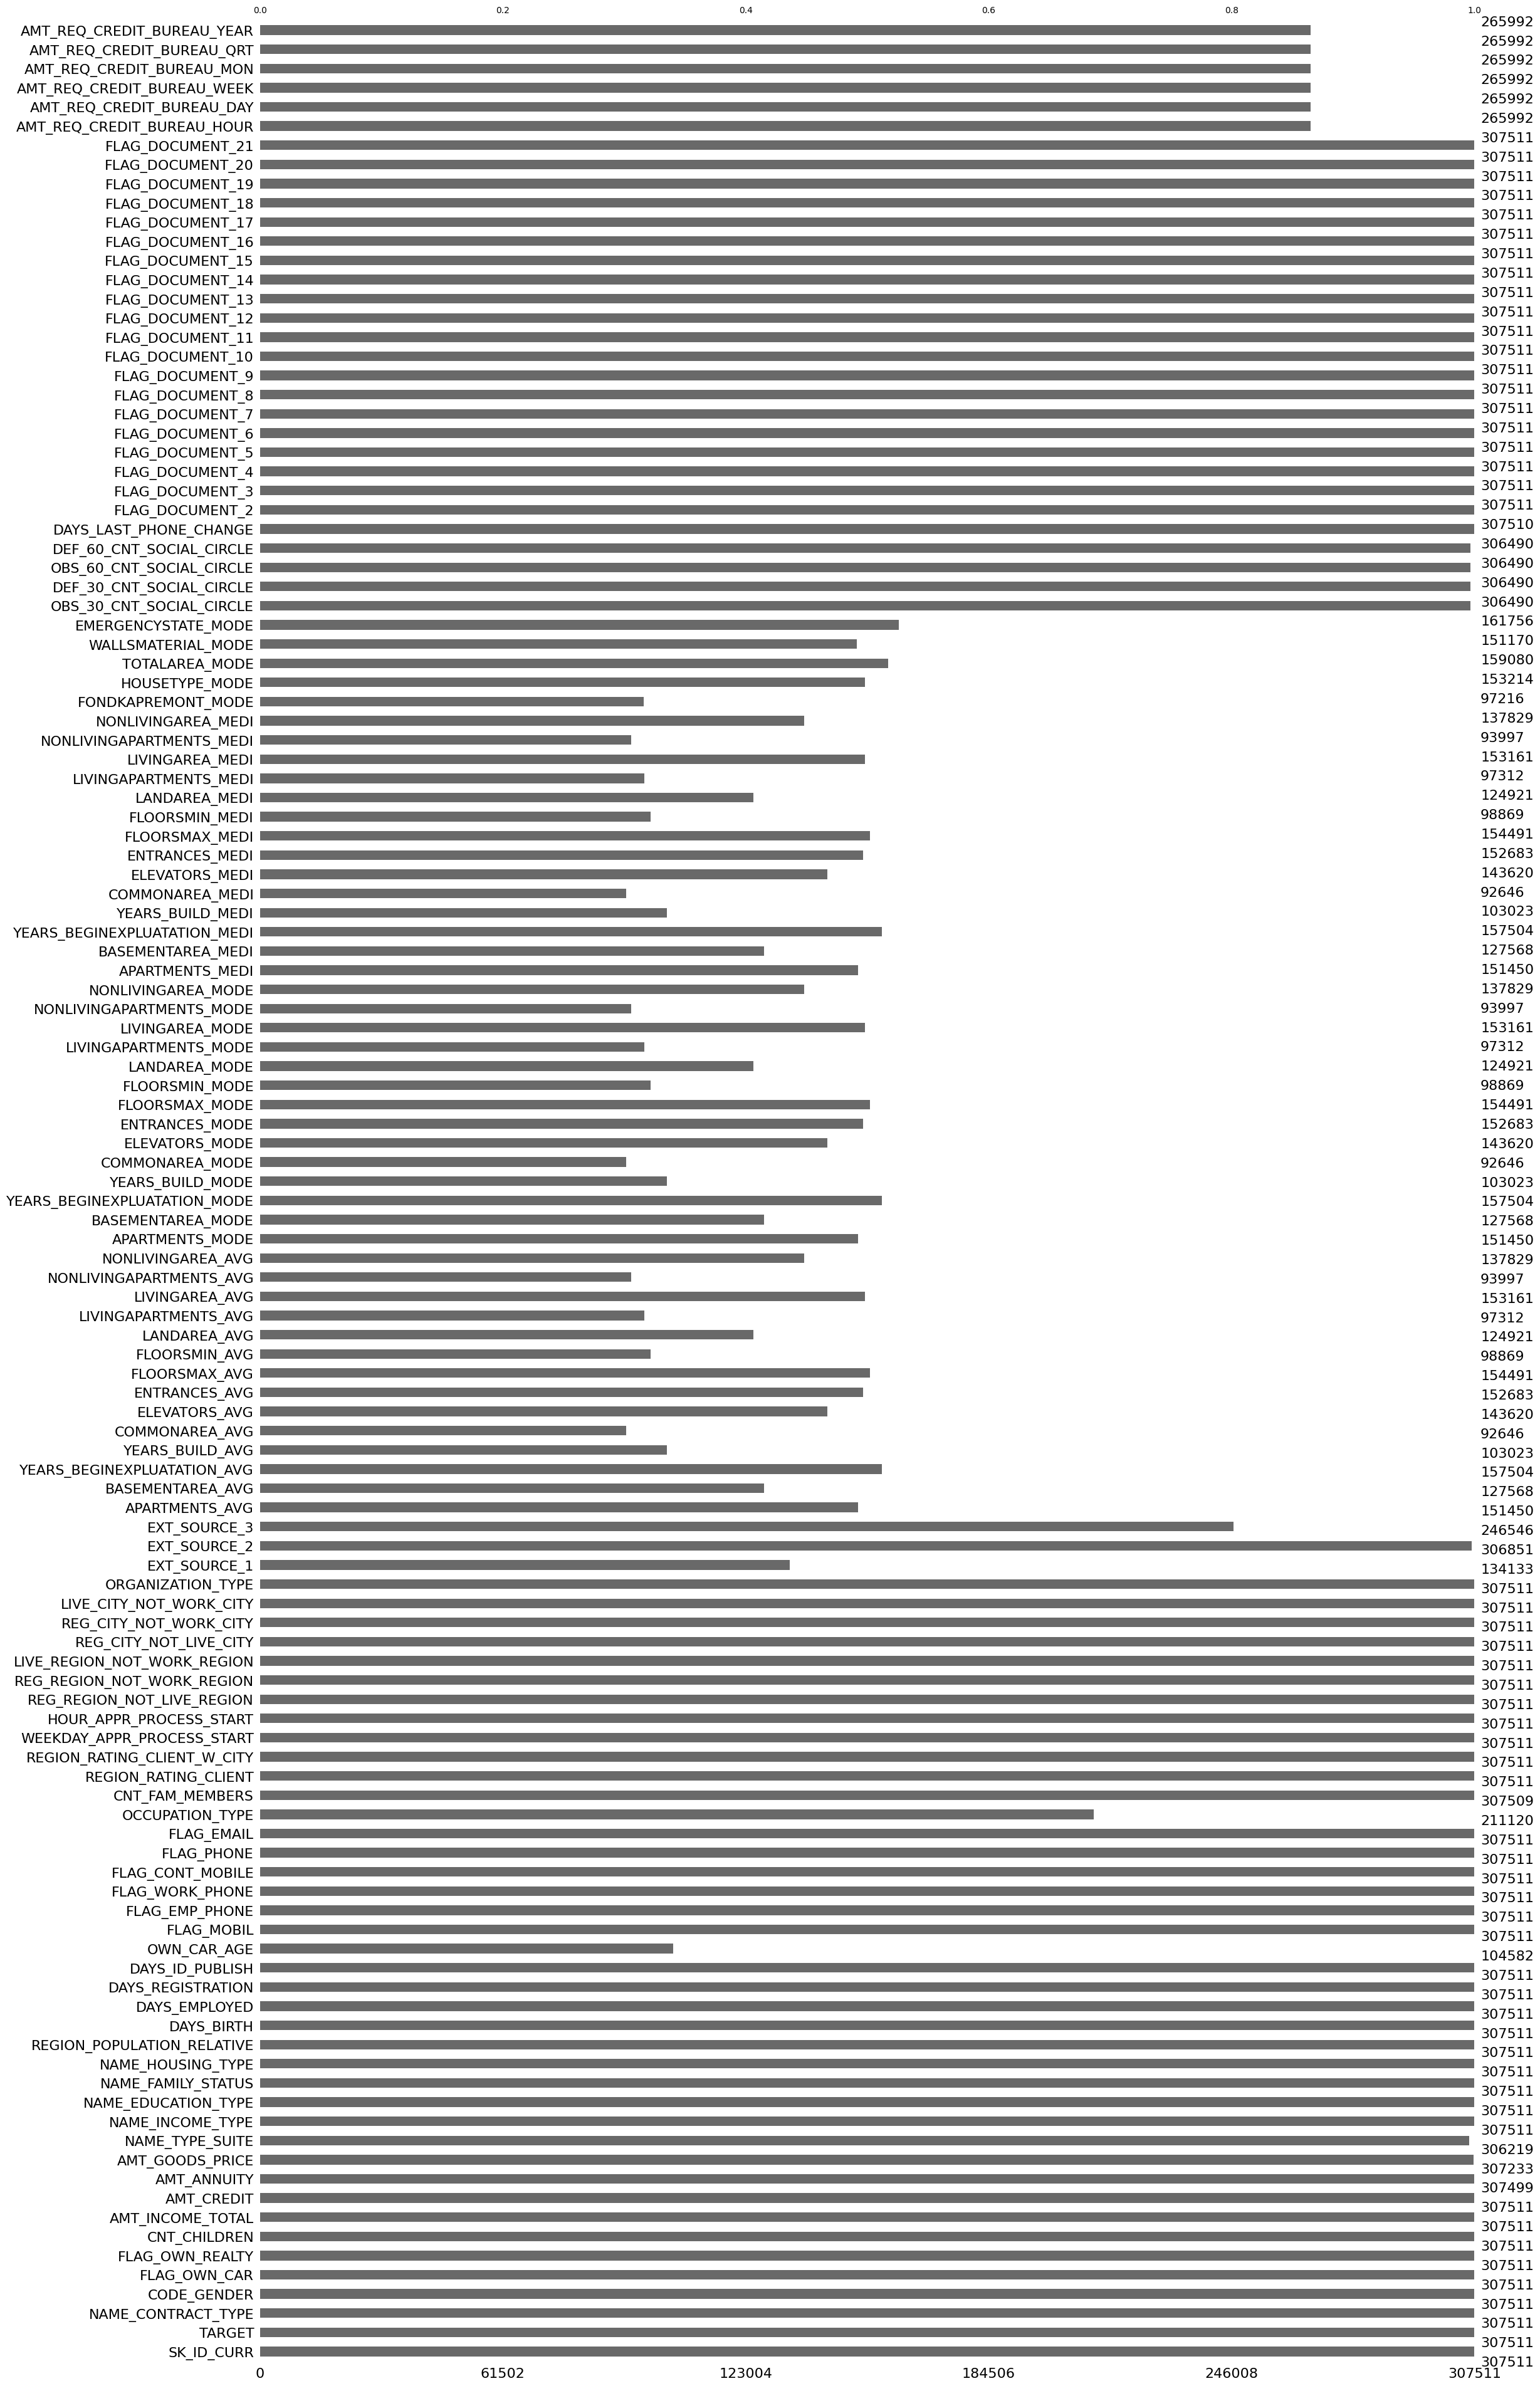

In [22]:
msno.bar(df_train)
plt.show()

<Axes: >

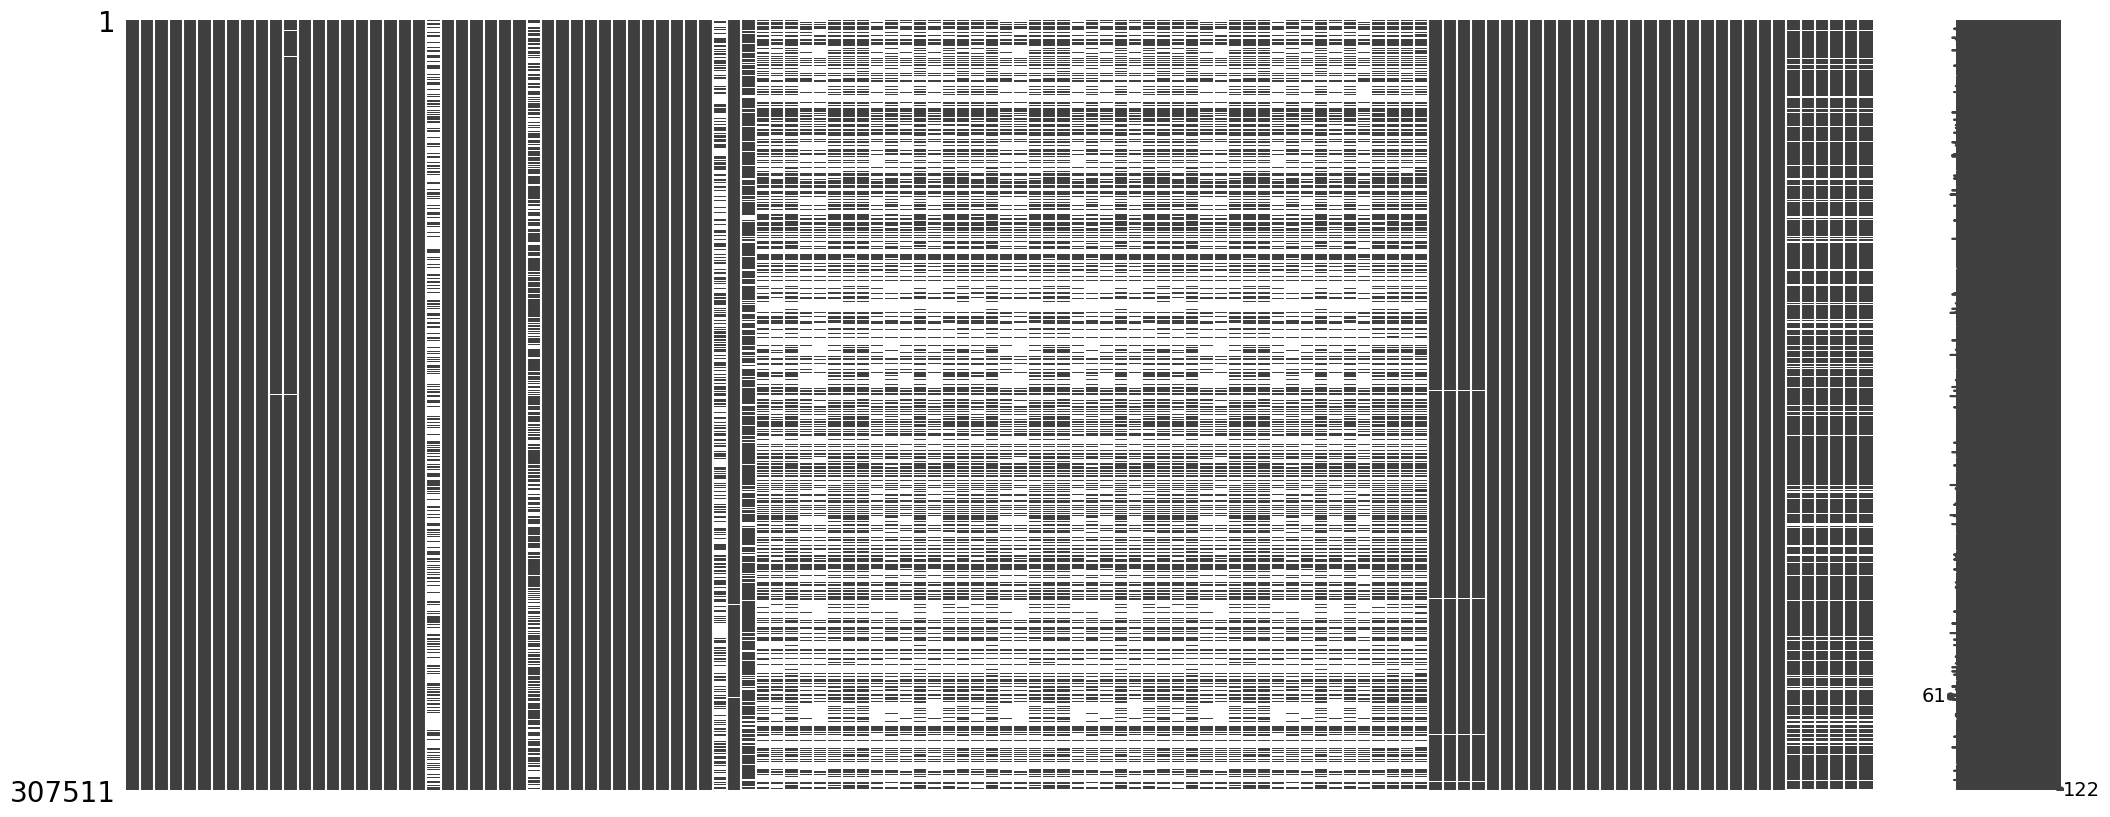

In [23]:
msno.matrix(df_train)

In [24]:
def missing_values_table(dataframe, na_name=False):
    na_cols = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_cols].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_cols].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    n_miss_cols = ratio[ratio > 10.0].index
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end='\n')
    if na_name:
        return na_cols, n_miss_cols

In [25]:
na_cols, n_miss_cols = missing_values_table(df_train, True)

                          n_miss  ratio
COMMONAREA_MEDI           214865  69.87
COMMONAREA_AVG            214865  69.87
COMMONAREA_MODE           214865  69.87
NONLIVINGAPARTMENTS_MEDI  213514  69.43
NONLIVINGAPARTMENTS_MODE  213514  69.43
...                          ...    ...
EXT_SOURCE_2                 660   0.21
AMT_GOODS_PRICE              278   0.09
AMT_ANNUITY                   12   0.00
CNT_FAM_MEMBERS                2   0.00
DAYS_LAST_PHONE_CHANGE         1   0.00

[67 rows x 2 columns]


In [26]:
n_miss_cols

Index(['COMMONAREA_MEDI', 'COMMONAREA_AVG', 'COMMONAREA_MODE',
       'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE',
       'NONLIVINGAPARTMENTS_AVG', 'FONDKAPREMONT_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_MEDI',
       'LIVINGAPARTMENTS_AVG', 'FLOORSMIN_MODE', 'FLOORSMIN_MEDI',
       'FLOORSMIN_AVG', 'YEARS_BUILD_MODE', 'YEARS_BUILD_MEDI',
       'YEARS_BUILD_AVG', 'OWN_CAR_AGE', 'LANDAREA_AVG', 'LANDAREA_MEDI',
       'LANDAREA_MODE', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_AVG',
       'BASEMENTAREA_MODE', 'EXT_SOURCE_1', 'NONLIVINGAREA_MEDI',
       'NONLIVINGAREA_MODE', 'NONLIVINGAREA_AVG', 'ELEVATORS_MEDI',
       'ELEVATORS_MODE', 'ELEVATORS_AVG', 'WALLSMATERIAL_MODE',
       'APARTMENTS_MODE', 'APARTMENTS_MEDI', 'APARTMENTS_AVG',
       'ENTRANCES_MODE', 'ENTRANCES_AVG', 'ENTRANCES_MEDI', 'LIVINGAREA_MEDI',
       'LIVINGAREA_MODE', 'LIVINGAREA_AVG', 'HOUSETYPE_MODE', 'FLOORSMAX_MEDI',
       'FLOORSMAX_AVG', 'FLOORSMAX_MODE', 'YEARS_BEGINEXPLUATATION_AVG'

### Drop Missing Value Bigger than Average

In [27]:
df_train.drop(n_miss_cols, axis=1, inplace=True)

In [28]:
na_cols, n_miss_cols = missing_values_table(df_train, True)

                          n_miss  ratio
NAME_TYPE_SUITE             1292   0.42
OBS_30_CNT_SOCIAL_CIRCLE    1021   0.33
DEF_30_CNT_SOCIAL_CIRCLE    1021   0.33
OBS_60_CNT_SOCIAL_CIRCLE    1021   0.33
DEF_60_CNT_SOCIAL_CIRCLE    1021   0.33
EXT_SOURCE_2                 660   0.21
AMT_GOODS_PRICE              278   0.09
AMT_ANNUITY                   12   0.00
CNT_FAM_MEMBERS                2   0.00
DAYS_LAST_PHONE_CHANGE         1   0.00


### Imputer Another Missing Value

In [29]:
from sklearn.impute import KNNImputer

In [30]:
imputer = KNNImputer(n_neighbors=5)

In [31]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_train)

Observations: 307511
Variables: 65
cat_cols: 51
num_cols: 12
cat_but_car: 1
num_but_cat: 41


In [32]:
na_num_cols = df_train[na_cols].select_dtypes(include='float').columns

In [33]:
df_train[na_num_cols] = pd.DataFrame(imputer.fit_transform(df_train[na_num_cols]), columns=df_train[na_num_cols].columns)

In [34]:
na_cols, n_miss_cols = missing_values_table(df_train, True)

                 n_miss  ratio
NAME_TYPE_SUITE    1292   0.42


### Imputer Categorical Columns

In [35]:
name_type_col_mode = df_train[na_cols].value_counts().index[0][0]
name_type_col_mode

'Unaccompanied'

In [36]:
df_train.loc[df_train[na_cols].isnull().NAME_TYPE_SUITE.values, na_cols] = name_type_col_mode

In [37]:
df_train[na_cols].isnull().sum()

NAME_TYPE_SUITE    0
dtype: int64

In [38]:
df_train['TARGET'].values

array([1, 0, 0, ..., 0, 1, 0])

## Encoding

### Label Encoding

In [39]:
def label_encoder(dataframe, binary_col):
    labelEncoder = LabelEncoder()
    dataframe[binary_col] = labelEncoder.fit_transform(dataframe[binary_col])
    return dataframe

In [40]:
binary_cols = [col for col in df_train.columns if df_train[col].dtypes not in ['int64', 'float64'] and df_train[col].nunique() == 2]

In [41]:
for col in binary_cols:
    label_encoder(df_train, col)

In [42]:
df_train[cat_cols].head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,WEEKDAY_APPR_PROCESS_START,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,0,M,0,1,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,WEDNESDAY,...,0,0,0,0,0,0,0,0,0,0
1,0,F,0,0,Family,State servant,Higher education,Married,House / apartment,MONDAY,...,0,0,0,0,0,0,0,0,0,0
2,1,M,1,1,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,MONDAY,...,0,0,0,0,0,0,0,0,0,0
3,0,F,0,1,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,WEDNESDAY,...,0,0,0,0,0,0,0,0,0,0
4,0,M,0,1,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,THURSDAY,...,0,0,0,0,0,0,0,0,0,0


In [43]:
for col in cat_cols:
    print(df_train[col].value_counts())
    print("----------------------------")

NAME_CONTRACT_TYPE
0    278232
1     29279
Name: count, dtype: int64
----------------------------
CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64
----------------------------
FLAG_OWN_CAR
0    202924
1    104587
Name: count, dtype: int64
----------------------------
FLAG_OWN_REALTY
1    213312
0     94199
Name: count, dtype: int64
----------------------------
NAME_TYPE_SUITE
Unaccompanied      249818
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: count, dtype: int64
----------------------------
NAME_INCOME_TYPE
Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: count, dtype: int64
----------------------------
NAME_EDUCATION_TYPE
Secondary / s

## Data Analysis

In [44]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_train)

Observations: 307511
Variables: 65
cat_cols: 48
num_cols: 15
cat_but_car: 1
num_but_cat: 41


In [45]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("****************************************************")

    if plot:
        sns.countplot(x=col_name, data=dataframe)
        plt.show(block=True)


In [46]:
for col in cat_cols:
    cat_summary(df_train, col)

             CODE_GENDER      Ratio
CODE_GENDER                        
F                 202448  65.834393
M                 105059  34.164306
XNA                    4   0.001301
****************************************************
                 NAME_TYPE_SUITE      Ratio
NAME_TYPE_SUITE                            
Unaccompanied             249818  81.238720
Family                     40149  13.056118
Spouse, partner            11370   3.697429
Children                    3267   1.062401
Other_B                     1770   0.575589
Other_A                      866   0.281616
Group of people              271   0.088127
****************************************************
                      NAME_INCOME_TYPE      Ratio
NAME_INCOME_TYPE                                 
Working                         158774  51.631974
Commercial associate             71617  23.289248
Pensioner                        55362  18.003258
State servant                    21703   7.057634
Unemployed        

In [47]:
cat_cols = [col for col in cat_cols if df_train[col].nunique() > 2 and df_train[col].dtypes not in ['float', 'int']]
cat_cols

['CODE_GENDER',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'WEEKDAY_APPR_PROCESS_START']

In [48]:
def plot_cat_cols(df_train, cat_cols):
    width_cols = 3
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 14))
    plt.subplots_adjust(right=2)
    plt.subplots_adjust(top=2)
    for i, col in enumerate(cat_cols, start=1):
        plt.subplot(math.ceil(len(cat_cols) / width_cols), width_cols, i)
        sns.countplot(x=col, data=df_train, saturation=1,);
        plt.xlabel(col, fontsize=18)
        plt.ylabel("Count", fontsize=16)
        plt.xticks(fontsize=16, rotation=45, ha='right')
        plt.yticks(fontsize=14)

    plt.show();

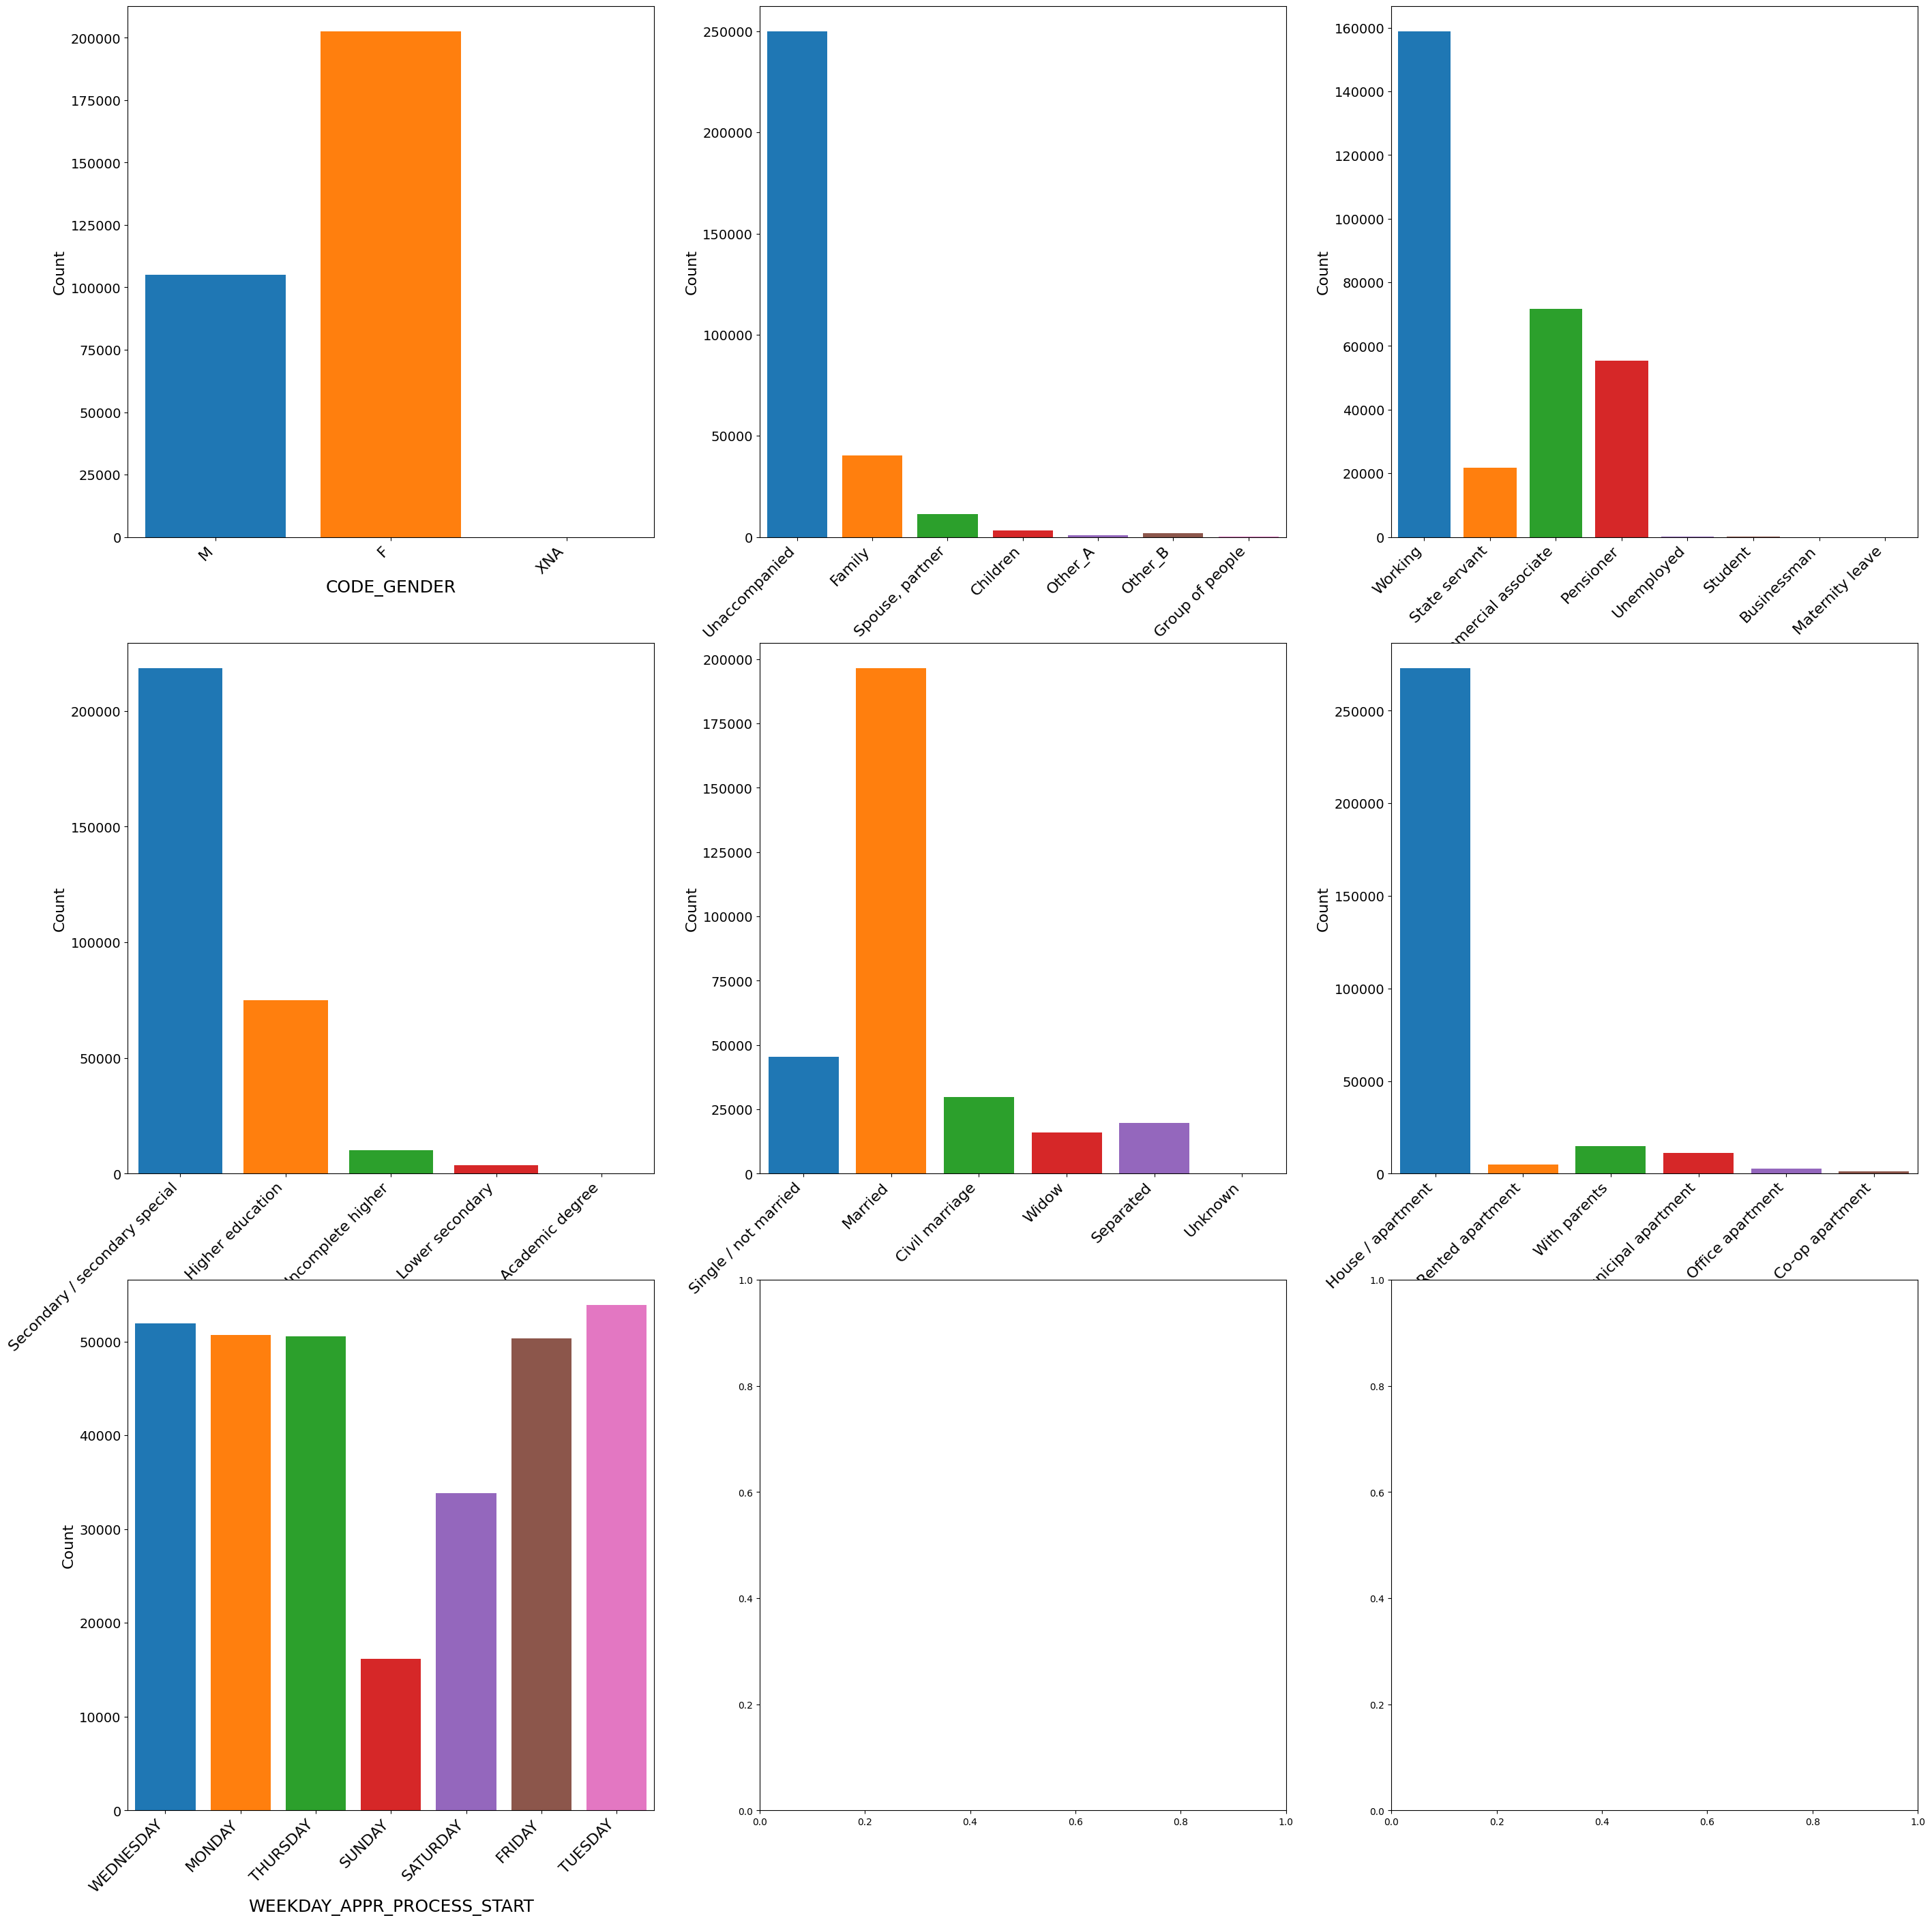

In [49]:
plot_cat_cols(df_train, cat_cols)